In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from skimage.color import rgb2lab
from PIL import Image
import numpy as np

In [11]:
# Data Preparation
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([transforms.Resize((400, 400)),
                                    transforms.ToTensor()])
    img = transform(image)
    x = np.array(image)/255.0
    lab_image = rgb2lab(np.array(image))
    X = lab_image[:, :, 0]
    Y = lab_image[:, :, 1:] / 128.0
    X = X.reshape(1, 1, 400, 400)
    Y = Y.reshape(1, 2, 400, 400)
    return torch.Tensor(X), torch.Tensor(Y)

# preprocess_image('woman.jpg')

In [12]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3,padding=1, stride=2),  # Assuming grayscale input images
            nn.ReLU(),
            nn.Conv2d(8, 8, 3,padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3,padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3,padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3,padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3,padding=1, stride=2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(16, 2, 3, padding=1),
            nn.Sigmoid()  # Using Sigmoid as the final activation
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x * 128.0


In [13]:
model = ColorizationModel()

# defining loss and optmizer
criterion = nn.MSELoss()
optimizer = optim.RMSprop(params=model.parameters(), lr=0.001) 

In [35]:
for epoch in range(100):
    X, Y = preprocess_image('woman.jpg')
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, Y)
    loss.backward()
    optimizer.step()

In [37]:
model.eval()
with torch.no_grad():
    X, _ = preprocess_image('woman.jpg')
    output = model(X)
    output *= 128

print(loss.item())


0.009407883509993553


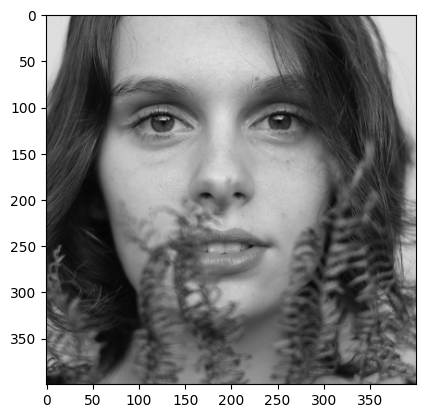

torch.Size([1, 400, 1, 400])
torch.Size([1, 2, 400, 400])


In [39]:
from skimage.color import lab2rgb
output_np = torch.cat((X, output), dim=1).squeeze().permute(1, 2, 0).numpy()
plt.imshow(lab2rgb(output_np))
plt.show()
print(X.shape)
print(output.shape)
